In [1]:
!git clone https://github.com/rainyliurunlin/SkinMatch.git
%cd SkinMatch
!ls

Cloning into 'SkinMatch'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 39 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 541.77 KiB | 2.94 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/SkinMatch
data  notebooks  src


In [2]:
import sys
sys.path.append("/content/SkinMatch/src")

In [3]:
import skin_match
print("Imported skin_match successfully.")

Imported skin_match successfully.


In [4]:
import pandas as pd

df = pd.read_csv("data/skincare_ingredients.csv")
df.shape, df.columns

((1472, 11),
 Index(['Label', 'brand', 'name', 'price', 'rank', 'ingredients', 'Combination',
        'Dry', 'Normal', 'Oily', 'Sensitive'],
       dtype='object'))

# SkinMatch: Ingredient-Based Skincare Analytics & Recommendation System

**Author:** Runlin Liu  

SkinMatch is a data-driven skincare analytics project designed to explore how cosmetic ingredients, product categories, and skin-type suitability relate to pricing, user ratings, and product effectiveness.

Using a real-world skincare ingredients dataset, this project aims to:

- Analyze ingredient composition and product characteristics across skincare categories
- Engineer interpretable features such as ingredient count, primary skincare effect, and irritation risk
- Identify pricing and rating patterns through exploratory data analysis
- Demonstrate a rule-based recommendation system tailored to different skin types and skincare goals

This notebook serves as an end-to-end demonstration of the SkinMatch analytics pipeline, while the core logic is implemented as reusable Python modules under `src/skin_match`.

## Data Source and Problem Statement

The dataset used in this project is a publicly available skincare product dataset containing information on:

- Product category and brand
- Price and user rating
- Full ingredient lists
- Binary indicators for skin-type suitability (Combination, Dry, Normal, Oily, Sensitive)

**Problem motivation:**

Skincare consumers often struggle to evaluate products beyond marketing claims. Ingredient lists are complex, and relationships between ingredients, skin types, price, and perceived effectiveness are not always obvious.

This project explores the following questions:

1. How do price and user ratings vary across product categories and primary skincare effects?
2. Can ingredient-level features help characterize products in a meaningful and interpretable way?
3. How can simple rules based on ingredients and skin type be used to generate personalized product recommendations?


In [5]:
import pandas as pd

df = pd.read_csv("data/skincare_ingredients.csv")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1472, 11)


,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


## Initial Data Inspection

Before cleaning and feature engineering, we perform a quick inspection of the raw dataset to understand its structure, data types, and potential issues.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   brand        1472 non-null   object 
 2   name         1472 non-null   object 
 3   price        1472 non-null   int64  
 4   rank         1472 non-null   float64
 5   ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


In [7]:
# --- Setup: clone repo & import local package ---
import sys, os

REPO_DIR = "/content/SkinMatch"
SRC_DIR = os.path.join(REPO_DIR, "src")

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

import skin_match
print("Imported skin_match successfully.")

Imported skin_match successfully.


In [8]:
import pandas as pd

DATA_PATH = os.path.join(REPO_DIR, "data", "skincare_ingredients.csv")
df_raw = pd.read_csv(DATA_PATH)

print("Raw shape:", df_raw.shape)
display(df_raw.head(3))
df_raw.info()

Raw shape: (1472, 11)


,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   brand        1472 non-null   object 
 2   name         1472 non-null   object 
 3   price        1472 non-null   int64  
 4   rank         1472 non-null   float64
 5   ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


In [9]:
import pandas as pd

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # standardize column names (optional)
    df.columns = [c.strip() for c in df.columns]

    # drop duplicates
    df = df.drop_duplicates()

    # strip text columns
    for col in ["Label", "brand", "name", "ingredients"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

    # enforce numeric types
    if "price" in df.columns:
        df["price"] = pd.to_numeric(df["price"], errors="coerce")
    if "rank" in df.columns:
        df["rank"] = pd.to_numeric(df["rank"], errors="coerce")

    # drop rows missing key fields
    df = df.dropna(subset=["Label", "brand", "name", "price", "rank", "ingredients"])

    return df

## Data Cleaning

The cleaning pipeline standardizes text fields, removes duplicates,
ensures consistent data types, and filters incomplete records.

After cleaning, the dataset remains at 1,472 products with no missing values,
preserving the original dataset size while improving analytical reliability.

In [10]:
from skin_match import clean_dataframe

df = clean_dataframe(df_raw)

print("Cleaned shape:", df.shape)
display(df.head(3))
df.isna().sum()

Cleaned shape: (1472, 11)


,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"algae (seaweed) extract, mineral oil, petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"galactomyces ferment filtrate (pitera), butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"water, dicaprylyl carbonate, glycerin, ceteary...",1,1,1,1,0


,0
Label,0
brand,0
name,0
price,0
rank,0
ingredients,0
Combination,0
Dry,0
Normal,0
Oily,0


In [11]:
print("Before:", df_raw.shape)
print("After :", df.shape)

Before: (1472, 11)
After : (1472, 11)


In [12]:
df.describe(include="all").T.head(12)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Label,1472,6,Moisturizer,298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,1472,116,CLINIQUE,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,1472,1472,Mineral Sport Sunscreen Stick SPF 50,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1472.0,NaN,NaN,NaN,55.584239,45.014429,3.0,30.0,42.5,68.0,370.0
rank,1472.0,NaN,NaN,NaN,4.153261,0.633918,0.0,4.0,4.3,4.5,5.0
ingredients,1472,1333,no info,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Combination,1472.0,NaN,NaN,NaN,0.65625,0.47512,0.0,0.0,1.0,1.0,1.0
Dry,1472.0,NaN,NaN,NaN,0.61413,0.486965,0.0,0.0,1.0,1.0,1.0
Normal,1472.0,NaN,NaN,NaN,0.652174,0.476442,0.0,0.0,1.0,1.0,1.0
Oily,1472.0,NaN,NaN,NaN,0.607337,0.488509,0.0,0.0,1.0,1.0,1.0


## Feature Engineering

To enable deeper analysis, I derived several interpretable features, including:

- Ingredient count per product
- Primary skincare effect classification
- Risk-related indicators based on ingredient patterns

These engineered features allow analysis beyond raw product metadata.

In [13]:
from skin_match.features import add_basic_features

df_feat = add_basic_features(df)
df_feat.head()

,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,Sensitive,ingredients_clean,ingredient_count,primary_effect,risk_score
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"algae (seaweed) extract, mineral oil, petrolat...",1,1,1,1,1,"algae (seaweed) extract, mineral oil, petrolat...",42,soothing_barrier,9
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"galactomyces ferment filtrate (pitera), butyle...",1,1,1,1,1,"galactomyces ferment filtrate (pitera), butyle...",7,hydrating,0
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"water, dicaprylyl carbonate, glycerin, ceteary...",1,1,1,1,0,"water, dicaprylyl carbonate, glycerin, ceteary...",59,hydrating,2
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"algae (seaweed) extract, cyclopentasiloxane, p...",1,1,1,1,1,"algae (seaweed) extract, cyclopentasiloxane, p...",78,hydrating,6
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"water, snail secretion filtrate, phenyl trimet...",1,1,1,1,1,"water, snail secretion filtrate, phenyl trimet...",83,hydrating,0


## Analytical Data Mart

A focused data mart was created by isolating variables relevant to pricing,
ratings, skincare effects, and skin-type suitability.

This structure simplifies downstream analysis and improves reproducibility.


In [14]:
from skin_match.mart import build_mart

df_mart = build_mart(df_feat)
df_mart.head()

,brand,Label,name,price,rank,ingredient_count,primary_effect,risk_score,Combination,Dry,Normal,Oily,Sensitive
0,LA MER,Moisturizer,Crème de la Mer,175,4.1,42,soothing_barrier,9,1,1,1,1,1
1,SK-II,Moisturizer,Facial Treatment Essence,179,4.1,7,hydrating,0,1,1,1,1,1
2,DRUNK ELEPHANT,Moisturizer,Protini™ Polypeptide Cream,68,4.4,59,hydrating,2,1,1,1,1,0
3,LA MER,Moisturizer,The Moisturizing Soft Cream,175,3.8,78,hydrating,6,1,1,1,1,1
4,IT COSMETICS,Moisturizer,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,83,hydrating,0,1,1,1,1,1


## Exploratory Analysis

### 1. Price Distribution by Primary Effect


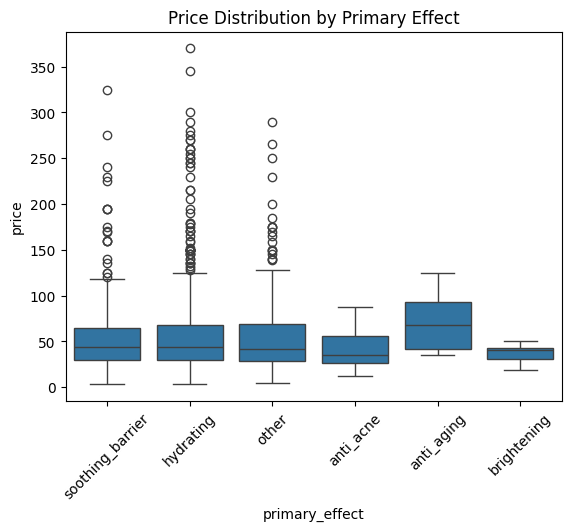

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=df_mart, x="primary_effect", y="price")
plt.title("Price Distribution by Primary Effect")
plt.xticks(rotation=45)
plt.show()

### 2. Rating Distribution Across Product Categories


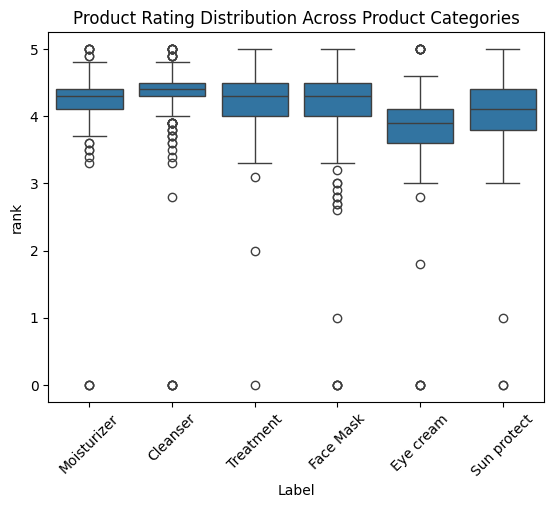

In [17]:
sns.boxplot(data=df_mart, x="Label", y="rank")
plt.xticks(rotation=45)
plt.title("Product Rating Distribution Across Product Categories")
plt.show()

## Recommendation Prototype

Based on engineered features and skin-type labels, a simple rule-based
recommendation function selects top-rated products suitable for a given skin type.

This prototype demonstrates how analytical insights can be translated
into user-facing decision support.


In [18]:
from skin_match.recommend import recommend_top_products

recommend_top_products(
    df_mart,
    skin_type="Oily",
    top_n=5
)

=== SkinMatch Recommendation ===
Skin type: Oily
Returned top 5 products.



,brand,Label,name,price,rank,primary_effect,risk_score,Combination,Dry,Normal,Oily,Sensitive
954,FOREO,Face Mask,Make My Day Hydrating & Anti-Pollution UFO™ Ac...,9,5.0,hydrating,0,1,1,1,1,1
1003,FOREO,Face Mask,H2Overdose Mask,19,5.0,soothing_barrier,0,1,1,1,1,1
1409,SUPERGOOP!,Sun protect,Invincible Setting Powder SPF 45 Refill,20,5.0,soothing_barrier,0,1,1,1,1,1
1017,DR ROEBUCK’S,Face Mask,Uluru Purifying Mask,28,5.0,hydrating,0,1,1,1,1,1
1458,COOLA,Sun protect,Sport Continuous Spray SPF 30 - Unscented,32,5.0,hydrating,0,1,1,1,1,1


## Conclusion & Future Work

This project demonstrates how structured data cleaning, feature engineering,
and exploratory analysis can support transparent skincare recommendations.

Future extensions may include:
- Ingredient embedding and similarity-based recommendation
- Sentiment analysis using product reviews
- A lightweight web interface for interactive exploration
